# Overview

In [17]:
import sys
import os
import math
from typing import Dict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))
from core.utils.data_loader import DataLoader
from core.utils.region_mapper import RegionMapper
from core.config.pipeline_config import PipelineConfig

In [2]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)

In [3]:
df = loader.load_csv_complete(config.paths.data_dir / "names.csv")

## Quantitative

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8069950.0,16.231662,20.139369,0.0,4.0,10.0,21.0,939.0
percentage,8069950.0,56.188421,5.403735,10.0,52.0,55.0,59.0,96.0
year,8069950.0,2017.599677,4.371243,2008.0,2015.0,2019.0,2021.0,2023.0
line,8069950.0,118021.649797,195762.213691,4.0,6957.0,19192.0,117146.0,826262.0


## Regions

In [15]:
table = (
    df['region']
    .value_counts()            # counts by frequency
    .rename_axis("Value")      # name the index
    .reset_index(name="Count") # make it a DataFrame
    .sort_values("Value")      # sort alphabetically
    .reset_index(drop=True)    # clean row index
)

table

,Value,Count
0,bandundu,165090
1,bandundu-1,37755
2,bandundu-2,75006
3,bandundu-3,27907
4,bas-congo,45604
...,...,...
120,tshopo-1,49612
121,tshopo-2,23624
122,tshuapa,13717
123,tshuapa-1,8206


## Subregions by Parent Region

In [38]:
def build_subregion_tables(series: pd.Series, mapper: RegionMapper) -> Dict[str, pd.DataFrame]:
    """
    Returns { PARENT -> DataFrame[subregion, count] }.
    Parent is the mapped province produced by RegionMapper.map().
    """
    s = series.astype(str).str.strip().str.lower()
    parents = mapper.map(s)
    df_regions = pd.DataFrame({"subregion": s, "parent": parents})
    counts = (
        df_regions.groupby(["parent", "subregion"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    out: Dict[str, pd.DataFrame] = {}
    for parent, g in counts.groupby("parent"):
        g = g.sort_values(["count", "subregion"], ascending=[False, True])
        out[parent] = g.reset_index(drop=True)
    return out


def plot_all_parents_grid(series: pd.Series, mapper: RegionMapper, per_row: int = 4):
    """
    Plot horizontal bar charts of subregion counts for every parent in
    RegionMapper.get_provinces(), arranged as a grid with `per_row` columns.
    """
    def truncate_label(l: str, max_len: int = 15) -> str:
        return l if len(l) <= max_len else l[:max_len - 3] + "..."

    # Build subregion tables once
    tables = build_subregion_tables(series, mapper)

    # Respect the explicit list of parents from RegionMapper
    parents = [p.upper() for p in mapper.get_provinces()]  # mapper.get_provinces() are lowercase
    n = len(parents)
    rows = math.ceil(n / per_row)

    # Make figure size scale with grid size
    fig_w = 6 * per_row
    fig_h = max(4.8 * rows, 3.5)  # minimum height
    fig, axes = plt.subplots(rows, per_row, figsize=(fig_w, fig_h))
    if rows == 1 and per_row == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif per_row == 1:
        axes = [[ax] for ax in axes]

    # Draw each parent's subplot
    for idx, parent in enumerate(parents):
        r = idx // per_row
        c = idx % per_row
        ax = axes[r][c]

        dfp = tables.get(parent)
        if dfp is None or dfp.empty:
            ax.set_title(parent)
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_axis_off()
            continue

        labels = [truncate_label(lbl, 15) for lbl in dfp["subregion"]]

        # Horizontal bar chart: y=subregion, x=count (sorted by count desc already)
        ax.barh(labels, dfp["count"])
        ax.set_title(parent)
        ax.set_xlabel("Count")
        ax.set_ylabel("Subregion")
        ax.invert_yaxis()  # largest at top
        # Improve readability with many labels
        for label in ax.get_yticklabels():
            label.set_fontsize(8)

    # Turn off any leftover empty axes
    total_axes = rows * per_row
    for j in range(n, total_axes):
        r = j // per_row
        c = j % per_row
        axes[r][c].set_axis_off()

    plt.tight_layout()
    plt.show()

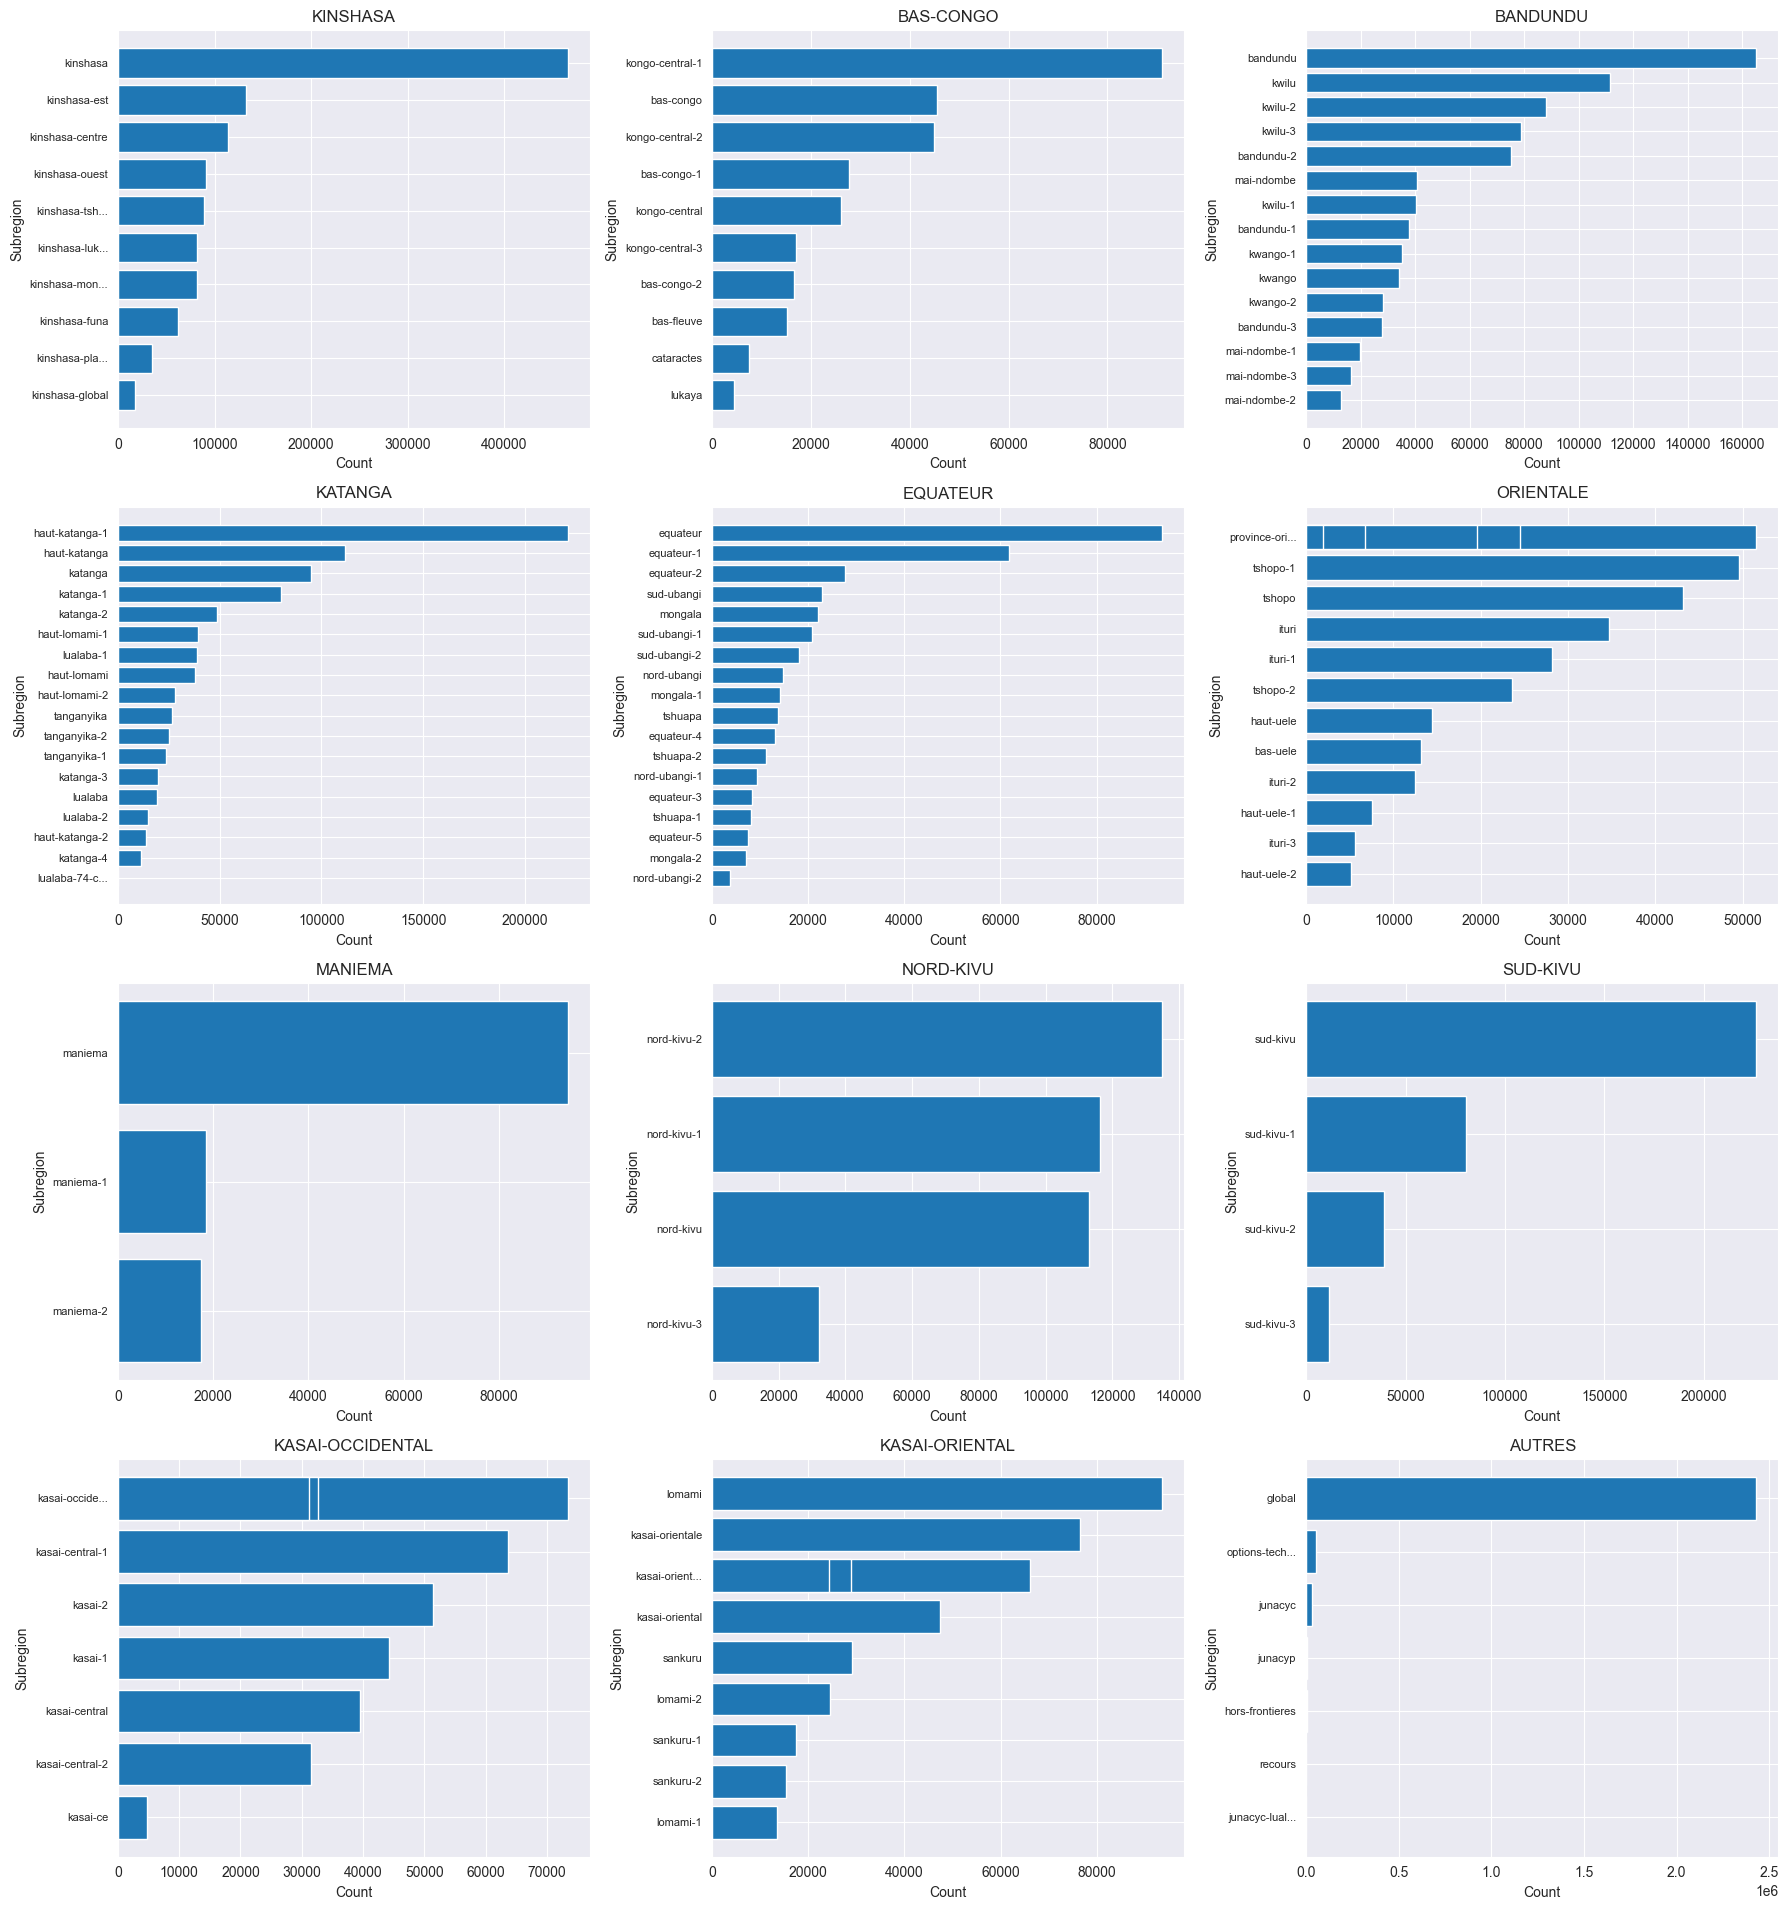

In [39]:
plot_all_parents_grid(df["region"], RegionMapper(), per_row=3)

# Year

In [40]:
table = (
    df['year']
    .value_counts()            # counts by frequency
    .rename_axis("Value")      # name the index
    .reset_index(name="Count") # make it a DataFrame
    .sort_values("Value")      # sort alphabetically
    .reset_index(drop=True)    # clean row index
)

table

,Value,Count
0,2008,183051
1,2009,256209
2,2010,280484
3,2011,323867
4,2012,322043
5,2013,270742
6,2014,330042
7,2015,729980
8,2016,387432
9,2017,402320


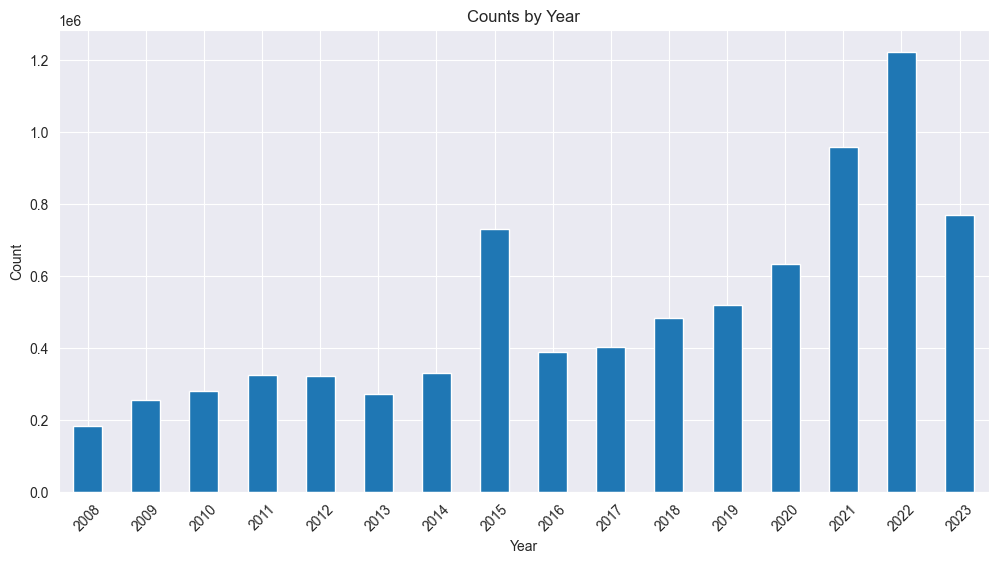

In [44]:
table.plot(
    x="Value",
    y="Count",
    kind="bar",
    figsize=(12, 6),
    legend=False
)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Counts by Year")
plt.xticks(rotation=45)  # rotate x labels for readability
plt.show()

In [48]:
def build_parent_year_tables(regions: pd.Series, years: pd.Series, mapper: RegionMapper) -> Dict[str, pd.DataFrame]:
    """
    Returns { PARENT -> DataFrame[year, count] } where count is the number of rows
    in that parent for each year (all subregions summed).
    """
    r = regions.astype(str).str.strip().str.lower()
    y = pd.to_numeric(years, errors="coerce").dropna().astype(int)
    # align after coercion
    df_regions = pd.DataFrame({"region": r, "year": years}).dropna(subset=["year"])
    df_regions["year"] = pd.to_numeric(df_regions["year"], errors="coerce").astype("Int64")
    df_regions = df_regions.dropna(subset=["year"])
    df_regions["year"] = df_regions["year"].astype(int)

    # Map to parent provinces via RegionMapper
    df_regions["parent"] = mapper.map(df_regions["region"])

    # Compute global year range so every parent gets the same y-axis domain
    if df_regions.empty:
        return {}
    year_min, year_max = df_regions["year"].min(), df_regions["year"].max()
    full_year_index = pd.Index(range(year_min, year_max + 1), name="year")

    # Group and build individual parent tables with missing years filled as 0
    g = df_regions.groupby(["parent", "year"]).size().rename("count").reset_index()
    tables: Dict[str, pd.DataFrame] = {}
    for parent, gp in g.groupby("parent"):
        gp = (gp.set_index("year")
        .reindex(full_year_index, fill_value=0)
        .rename_axis("year")
        .reset_index()[["year", "count"]])
        tables[parent] = gp.sort_values("year").reset_index(drop=True)
    return tables


def plot_all_parents_by_year_grid(regions: pd.Series, years: pd.Series, mapper: RegionMapper, per_row: int = 4):
    """
    Plot horizontal bar charts of yearly counts (summing all subregions) for each parent
    from RegionMapper.get_provinces(), arranged as a grid with `per_row` columns.
    """
    tables = build_parent_year_tables(regions, years, mapper)
    parents = [p.upper() for p in mapper.get_provinces()]  # keep your canonical ordering
    n = len(parents)
    rows = math.ceil(n / per_row)

    fig_w = 6 * per_row
    fig_h = max(4.8 * rows, 3.5)
    fig, axes = plt.subplots(rows, per_row, figsize=(fig_w, fig_h))
    if rows == 1 and per_row == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif per_row == 1:
        axes = [[ax] for ax in axes]

    for i, parent in enumerate(parents):
        r, c = divmod(i, per_row)
        ax = axes[r][c]

        dfp = tables.get(parent)
        if dfp is None or dfp.empty:
            ax.set_title(parent)
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_axis_off()
            continue

        # Horizontal bars: y = year (string for tidy ticks), x = count
        ylabels = dfp["year"].astype(str)
        ax.barh(ylabels, dfp["count"])
        ax.set_title(parent)
        ax.set_xlabel("Count")
        ax.set_ylabel("Year")
        ax.invert_yaxis()  # most recent year at top if desired; remove if you prefer ascending top->bottom

        # compact y tick labels
        for label in ax.get_yticklabels():
            label.set_fontsize(8)

    # Turn off any unused axes
    total_axes = rows * per_row
    for j in range(n, total_axes):
        r, c = divmod(j, per_row)
        axes[r][c].set_axis_off()

    plt.tight_layout()
    plt.show()


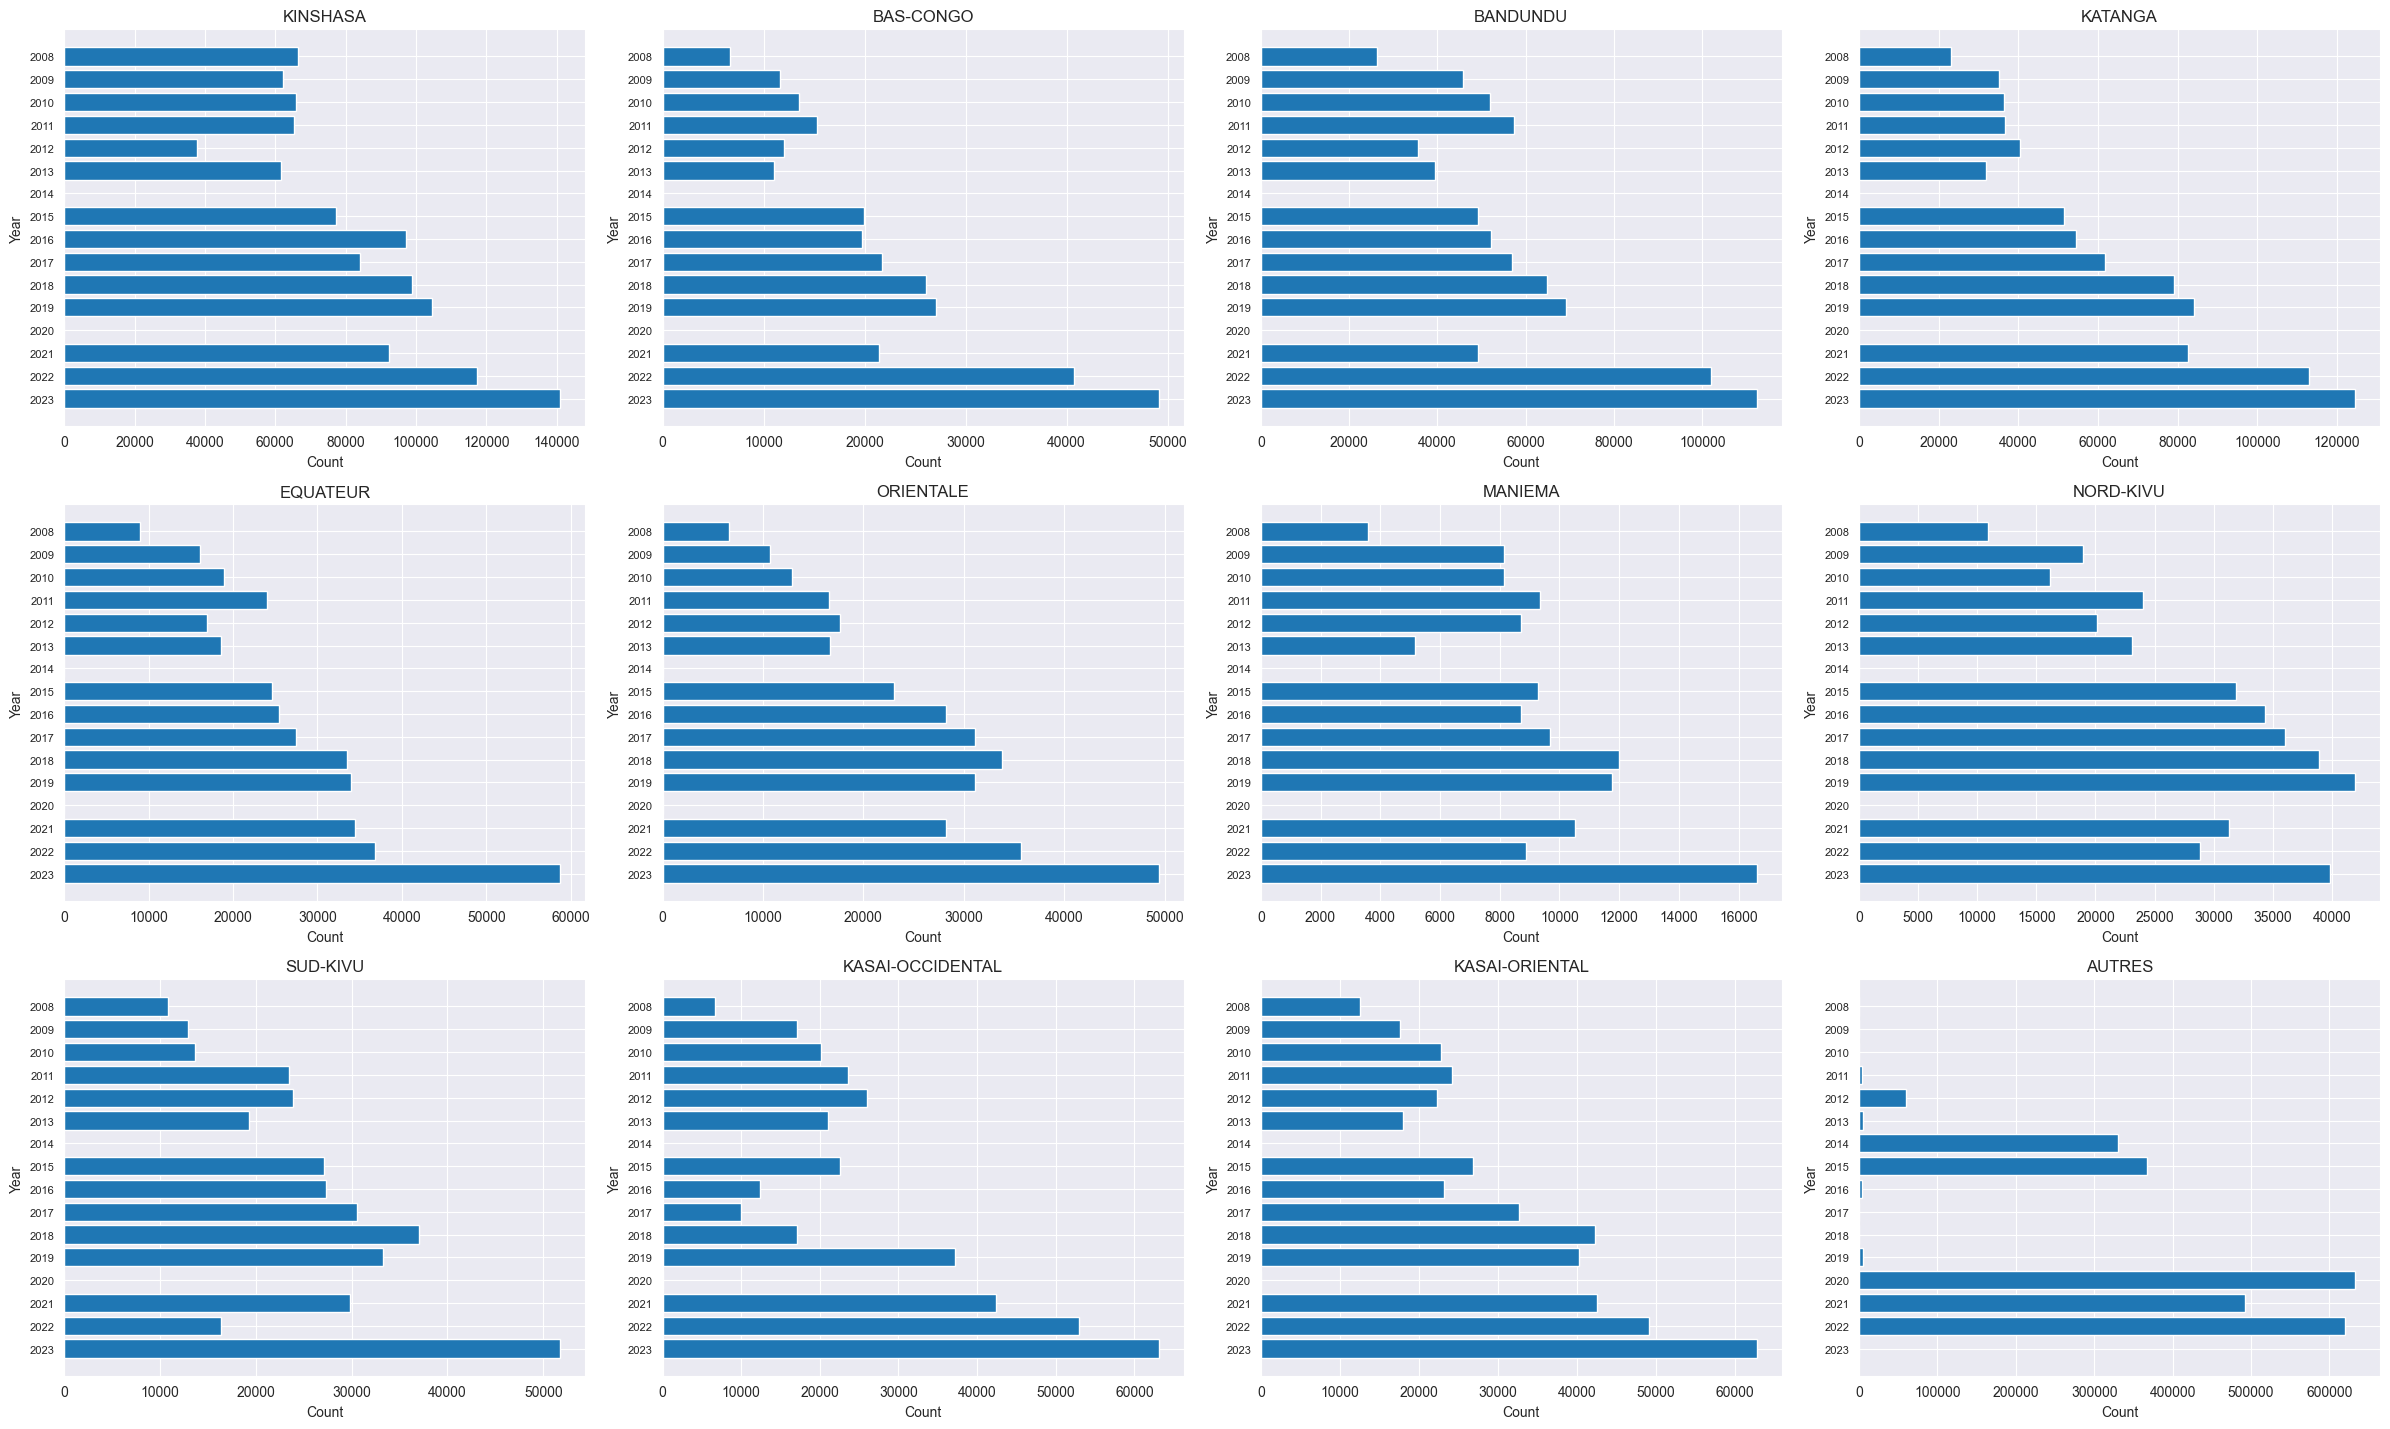

In [49]:
plot_all_parents_by_year_grid(df["region"], df["year"], RegionMapper(), per_row=4)